In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta
import yfinance as yf
import mplfinance as mpf
from shiny import reactive, render
from shiny.express import input, ui

In [2]:
def get_stock_price(ticker, start, end=None):
    ticker = f'{ticker}.T'
    if end is None:
        end = dt.today()

    #print(f'Start_date : {start.date()}\nEnd_date : {end.date()}')

    return_df = yf.download(ticker, start=start, end=end)
    return_df = return_df.stack(future_stack=True).reset_index()

    #print(f'Days : {return_df.shape[0]}')

    return return_df.set_index('Date')

In [3]:
start_date = dt.strptime('2023-07-01', '%Y-%m-%d').date()
start_date_100_days_ago = start_date - timedelta(days=100)
print(start_date_100_days_ago)

2023-03-23


In [4]:
df = get_stock_price(7974, start_date_100_days_ago, end='2024-10-10')

[*********************100%***********************]  1 of 1 completed


In [5]:
def draw_candle(df, start, end):
    data = df[(df.index.date>start.date()) & (df.index.date<end.date())].drop('Ticker', axis=1)
    
    #ろうそく足
    mpf.plot(data , type='candle', volume=True)

    plt.show()


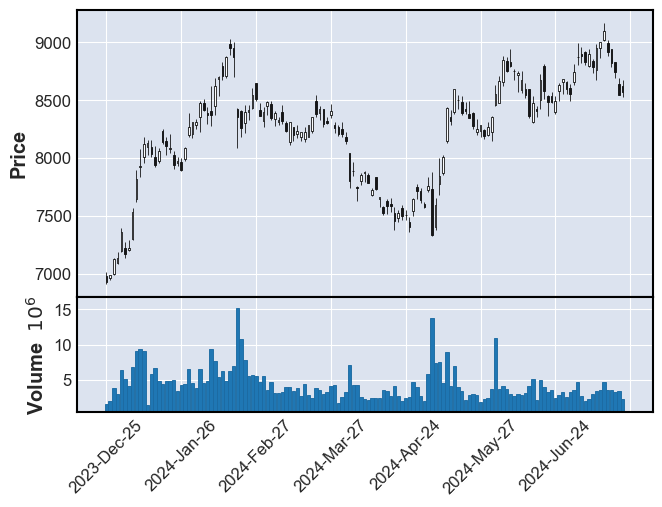

In [6]:
draw_candle(df, dt(2023, 12, 22), dt(2024, 7, 22))

In [7]:
import csv
def get_edinet_code(code):
    with open('EdinetcodeDlInfo.csv') as f:
        reader= csv.reader(f)
        #先頭行をスキップする
        next(reader)
        # 2行目以を項目行する
        col = next(reader)
        # 3行目以降をデータとする
        # rowは1行づつの配列となる。内包表記でまとめる
        data = [row for row in reader]
    
    edinet_codelist = pd.DataFrame(data, columns=col)
    return edinet_codelist[edinet_codelist['証券コード'] == f'{code}0']['ＥＤＩＮＥＴコード'].values[0]

In [8]:
get_edinet_code(4902)

'E00989'

In [9]:
import requests

# APIエンドポイント
api_url = 'https://disclosure.edinet-fsa.go.jp/api/v2/documents.json'

# パラメータ（例: 企業コードや提出日）
params = {
    'date': '2023-05-17',  # 提出日
    'type': 2,             # 提出書類の種類（有価証券報告書など）
    "Subscription-Key":"5c09c7cab09f4d98b34aa3f247f7e36d"
}

# APIリクエスト
response = requests.get(api_url, params=params)

# レスポンスの確認
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print("Error:", response.status_code)

documents = data['results']
df = pd.DataFrame(documents)
# 特定のカラムだけを選択
df_filtered = df[['docID', 'edinetCode', 'filerName', 'docDescription']]

# 決算情報のみをフィルタリング
df_financial = df_filtered[df_filtered['docDescription'].str.contains('有価証券報告書', na=False)]

edinet_code = get_edinet_code(7545)
df_financial[df_financial['edinetCode'] == edinet_code]

{'metadata': {'title': '提出された書類を把握するためのAPI', 'parameter': {'date': '2023-05-17', 'type': '2'}, 'resultset': {'count': 150}, 'processDateTime': '2024-11-07 00:02', 'status': '200', 'message': 'OK'}, 'results': [{'seqNumber': 1, 'docID': 'S100QNWL', 'edinetCode': 'E12444', 'secCode': None, 'JCN': '8010001114914', 'filerName': '三井住友トラスト・アセットマネジメント株式会社', 'fundCode': 'G10124', 'ordinanceCode': '030', 'formCode': '07A000', 'docTypeCode': '120', 'periodStart': '2022-08-18', 'periodEnd': '2023-02-17', 'submitDateTime': '2023-05-17 09:00', 'docDescription': '有価証券報告書（内国投資信託受益証券）－第19期(2022/08/18－2023/02/17)', 'issuerEdinetCode': None, 'subjectEdinetCode': None, 'subsidiaryEdinetCode': None, 'currentReportReason': None, 'parentDocID': None, 'opeDateTime': None, 'withdrawalStatus': '0', 'docInfoEditStatus': '0', 'disclosureStatus': '0', 'xbrlFlag': '1', 'pdfFlag': '1', 'attachDocFlag': '1', 'englishDocFlag': '0', 'csvFlag': '1', 'legalStatus': '1'}, {'seqNumber': 2, 'docID': 'S100QRM6', 'edinetCode

,docID,edinetCode,filerName,docDescription
93,S100QRRO,E03287,株式会社西松屋チェーン,有価証券報告書－第67期(2022/02/21－2023/02/20)


In [65]:
import requests
import pandas as pd
from datetime import datetime as dt, timedelta



# EDINET APIから指定された企業コードと日付に対応するdocIDを取得
def get_docID(code, date, api_key = "5c09c7cab09f4d98b34aa3f247f7e36d"):
    # APIエンドポイント
    api_url = 'https://disclosure.edinet-fsa.go.jp/api/v2/documents.json'

    # パラメータ（例: 企業コードや提出日）
    params = {
        'date': date,  # 提出日
        'type': 2,             # 提出書類の種類（有価証券報告書など）
        "Subscription-Key":str(api_key)
    }

    # APIリクエスト
    response = requests.get(api_url, params=params)

    # レスポンスの確認
    if response.status_code == 200:
        data = response.json()
    else:
        print("Error:", response.status_code)
        return None

    # ドキュメント情報を抽出
    documents = data['results']
    if documents == []:
        return None
    
    # 結果をDataFrameに変換
    df = pd.DataFrame(documents)

    # 特定のカラムだけを選択
    df_filtered = df[['docID', 'edinetCode', 'filerName', 'docDescription']]

    # 有価証券報告書のみにフィルタリング
    df_financial = df_filtered[df_filtered['docDescription'].str.contains('有価証券報告書', na=False)]
    
    # EDINETコードを取得してフィルタリング
    edinet_code = get_edinet_code(code)
    docID_data = df_financial[df_financial['edinetCode'] == edinet_code]
    

    
    # docIDを返す
    return docID_data['docID'].values[0]




In [66]:
date = str(dt(2023, 5, 17).date())
get_docID(7545, date)

'S100QRRO'

In [12]:
# メインのループ処理
flag = True
date = dt.today().date()
code = 4902
days = 0

while flag:
    print(date)
    try:
        docID = get_docID(code, str(date))
        if docID is not None:
            flag = False
            print("取得したdocID:", docID)
        else:
            # ドキュメントが見つからない場合、日付を1日前に戻す
            date -= timedelta(days=1)
    except IndexError:
        date -= timedelta(days=1)

    days += 1
    if days > 730:
        break

2024-11-07
2024-11-06
2024-11-05
2024-11-04
2024-11-03
2024-11-02
2024-11-01
2024-10-31
2024-10-30
2024-10-29
2024-10-28
2024-10-27
2024-10-26
2024-10-25
2024-10-24
2024-10-23
2024-10-22
2024-10-21
2024-10-20
2024-10-19
2024-10-18
2024-10-17
2024-10-16
2024-10-15
2024-10-14
2024-10-13
2024-10-12
2024-10-11
2024-10-10
2024-10-09
2024-10-08
2024-10-07
2024-10-06
2024-10-05
2024-10-04
2024-10-03
2024-10-02
2024-10-01
2024-09-30
2024-09-29
2024-09-28
2024-09-27
2024-09-26
2024-09-25
2024-09-24
2024-09-23
2024-09-22
2024-09-21
2024-09-20
2024-09-19
2024-09-18
2024-09-17
2024-09-16
2024-09-15
2024-09-14
2024-09-13
2024-09-12
2024-09-11
2024-09-10
2024-09-09
2024-09-08
2024-09-07
2024-09-06
2024-09-05
2024-09-04
2024-09-03
2024-09-02
2024-09-01
2024-08-31
2024-08-30
2024-08-29
2024-08-28
2024-08-27
2024-08-26
2024-08-25
2024-08-24
2024-08-23
2024-08-22
2024-08-21
2024-08-20
2024-08-19
2024-08-18
2024-08-17
2024-08-16
2024-08-15
2024-08-14
2024-08-13
2024-08-12
2024-08-11
2024-08-10


KeyboardInterrupt: 

In [14]:
import urllib.request
import sys
import os

# APIキーの設定
api_key = '5c09c7cab09f4d98b34aa3f247f7e36d'
url = f'https://api.edinet-fsa.go.jp/api/v2/documents/{docID}?type=5&Subscription-Key={api_key}'
try:
        # ZIPファイルのダウンロード
    with urllib.request.urlopen(url) as res:
        content = res.read()
    output_path = os.path.join("ignored_folder", f'{docID}.zip')
    with open(output_path, 'wb') as file_out:
        file_out.write(content)
except urllib.error.HTTPError as e:
    if e.code >= 400:
        sys.stderr.write(e.reason + '\n')
    else:
        raise e

In [15]:
import os
import zipfile

# 解凍フォルダのパスを設定（.gitignoreで無視されるフォルダの中に保存）
output_dir = os.path.join("ignored_folder", f"{docID}_extracted")

# 解凍処理
zip_path = os.path.join("ignored_folder", f'{docID}.zip')
try:
    # ZIP形式であり、ファイルサイズが0以上であるかチェック
    if zipfile.is_zipfile(zip_path) and os.path.getsize(zip_path) > 0:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # ファイル数を確認して空かどうかを判定
            if len(zip_ref.namelist()) > 0:
                os.makedirs(output_dir, exist_ok=True)  # 保存先フォルダが存在しない場合に作成
                zip_ref.extractall(output_dir)
                print(f"Extracted {zip_path} to {output_dir}")
            else:
                print(f"{zip_path} is an empty zip file.")
    else:
        print(f"{zip_path} is not a valid or empty zip file.")
except zipfile.BadZipFile:
    print(f"{zip_path} is corrupted or not a valid zip file.")

ignored_folder\None.zip is not a valid or empty zip file.


In [16]:
import shutil
extracted_folder = "ignored_folder"

# フォルダ内の全データを削除
if os.path.exists(extracted_folder):
    shutil.rmtree(extracted_folder)
    os.makedirs(extracted_folder)  # 空のフォルダを再作成
    print(f"Deleted all contents in: {extracted_folder}")
else:
    print(f"{extracted_folder} does not exist.")

Deleted all contents in: ignored_folder


In [17]:
import glob
import os

# フォルダ内の'-asr-'が含まれるCSVファイルを検索
folder_path = r'ignored_folder\S100TMYQ_extracted\XBRL_TO_CSV'  # 対象フォルダのパス
csv_files = glob.glob(os.path.join(folder_path, '*-asr-*.csv'))

# 見つかったCSVファイルを読み込む
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-16', sep='\t')
        print(f"Loaded {file} successfully.")
        # DataFrameの確認や処理が必要であればここに追加
        # 例: print(df.head())など
    except Exception as e:
        print(f"Error loading {file}: {e}")

In [18]:
path = r'C:\Users\kouki\Zemi\stock_analysis\S100QRRO_extracted\XBRL_TO_CSV\jpcrp030000-asr-001_E03287-000_2023-02-20_01_2023-05-17.csv'
df = pd.read_csv(path, encoding='utf-16', sep='\t')

In [ ]:
from datetime import datetime as dt

def get_nearest_quarter_end(current_date):
    # 現在の月を取得
    month = current_date.month

    # 四半期末日を設定
    if month <= 3:
        # 3月以下は前年の12月31日
        return current_date.replace(year=current_date.year - 1, month=12, day=31)
    elif month <= 6:
        return current_date.replace(month=3, day=31)  # 4月～6月は3月末
    elif month <= 9:
        return current_date.replace(month=6, day=30)  # 7月～9月は6月末
    else:
        return current_date.replace(month=9, day=30)  # 10月～12月は9月末

def search_docID(code):
    flag = True
    current_date = dt.today().date()
    date = get_nearest_quarter_end(current_date)
    days = 0

    while flag:
        print(date)
        try:
            docID = get_docID(code, str(date))
            if docID is not None:
                flag = False
                print("取得したdocID:", docID)
            else:
                # ドキュメントが見つからない場合、日付を1日前に戻す
                date -= timedelta(days=1)
        except IndexError:
            date -= timedelta(days=1)

        days += 1
        if days > 730:
            break
    return docID

def get_fs(docID):
    api_key = '5c09c7cab09f4d98b34aa3f247f7e36d'
    url = f'https://api.edinet-fsa.go.jp/api/v2/documents/{docID}?type=5&Subscription-Key={api_key}'
    try:
            # ZIPファイルのダウンロード
        with urllib.request.urlopen(url) as res:
            content = res.read()
        output_path = os.path.join("ignored_folder", f'{docID}.zip')
        with open(output_path, 'wb') as file_out:
            file_out.write(content)
    except urllib.error.HTTPError as e:
        if e.code >= 400:
            sys.stderr.write(e.reason + '\n')
        else:
            raise e    
    
    # 解凍フォルダのパスを設定（.gitignoreで無視されるフォルダの中に保存）
    output_dir = os.path.join("ignored_folder", f"{docID}_extracted")

    # 解凍処理
    zip_path = os.path.join("ignored_folder", f'{docID}.zip')
    try:
        # ZIP形式であり、ファイルサイズが0以上であるかチェック
        if zipfile.is_zipfile(zip_path) and os.path.getsize(zip_path) > 0:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # ファイル数を確認して空かどうかを判定
                if len(zip_ref.namelist()) > 0:
                    os.makedirs(output_dir, exist_ok=True)  # 保存先フォルダが存在しない場合に作成
                    zip_ref.extractall(output_dir)
                    print(f"Extracted {zip_path} to {output_dir}")
                else:
                    print(f"{zip_path} is an empty zip file.")
        else:
            print(f"{zip_path} is not a valid or empty zip file.")
    except zipfile.BadZipFile:
        print(f"{zip_path} is corrupted or not a valid zip file.")

    # フォルダ内の'-asr-'が含まれるCSVファイルを検索
    base_folder_path = r'ignored_folder'

    # パターンを指定してファイルパスを取得
    folder_pattern = os.path.join(base_folder_path, '*_extracted', 'XBRL_TO_CSV', '*-asr-*.csv')
    matching_folders = glob.glob(folder_pattern)
    file = matching_folders[0]

    # 見つかったCSVファイルを読み込む

    try:
        return_df = pd.read_csv(file, encoding='utf-16', sep='\t')
        print(f"Loaded {file} successfully.")
        # DataFrameの確認や処理が必要であればここに追加
        # 例: print(df.head())など
    except Exception as e:
        print(f"Error loading {file}: {e}")
    
    return return_df

def delete_files():
    extracted_folder = "ignored_folder"

    # フォルダ内の全データを削除
    if os.path.exists(extracted_folder):
        shutil.rmtree(extracted_folder)
        os.makedirs(extracted_folder)  # 空のフォルダを再作成
        print(f"Deleted all contents in: {extracted_folder}")
    else:
        print(f"{extracted_folder} does not exist.")

In [ ]:
docID = search_docID(4902)
df = get_fs(docID)
delete_files()

2024-09-30
2024-09-29
2024-09-28
2024-09-27
2024-09-26
2024-09-25
2024-09-24
2024-09-23
2024-09-22
2024-09-21
2024-09-20
2024-09-19
2024-09-18
2024-09-17
2024-09-16
2024-09-15
2024-09-14
2024-09-13
2024-09-12
2024-09-11
2024-09-10
2024-09-09
2024-09-08
2024-09-07
2024-09-06
2024-09-05
2024-09-04
2024-09-03
2024-09-02
2024-09-01
2024-08-31
2024-08-30
2024-08-29
2024-08-28
2024-08-27
2024-08-26
2024-08-25
2024-08-24
2024-08-23
2024-08-22
2024-08-21
2024-08-20
2024-08-19
2024-08-18
2024-08-17
2024-08-16
2024-08-15
2024-08-14
2024-08-13
2024-08-12
2024-08-11
2024-08-10
2024-08-09
2024-08-08
2024-08-07
2024-08-06
2024-08-05
2024-08-04
2024-08-03
2024-08-02
2024-08-01
2024-07-31
2024-07-30
2024-07-29
2024-07-28
2024-07-27
2024-07-26
2024-07-25
2024-07-24
2024-07-23
2024-07-22
2024-07-21
2024-07-20
2024-07-19
2024-07-18
2024-07-17
2024-07-16
2024-07-15
2024-07-14
2024-07-13
2024-07-12
2024-07-11
2024-07-10
2024-07-09
2024-07-08
2024-07-07
2024-07-06
2024-07-05
2024-07-04
2024-07-03
2024-07-02

In [20]:
def safe_to_float(x):
    try:
        return float(x)
    except ValueError:
        return x  # 変換できない場合は元の値を返す

# 定義した関数を適用
df['値'] = df['値'].apply(safe_to_float)

years = df[df['項目名'].str.contains('売上高', na=False)][:5]['相対年度']
sales = df[df['項目名'].str.contains('売上高', na=False)][:5]['値']
df_rro = pd.DataFrame({'相対年度':years, '売上高':sales}).reset_index(drop=True)

cols = ['経常利益', '純資産額', '総資産額', 
'１株当たり純資産額', '１株当たり配当額', '自己資本比率', 
'自己資本利益率', '株価収益率', 
'営業活動によるキャッシュ・フロー', '投資活動によるキャッシュ・フロー',
'財務活動によるキャッシュ・フロー', '従業員数']
for col in cols:
    df_rro[col] = df[df['項目名'].str.contains(f'{col}', na=False)][:5]['値'].reset_index(drop=True)
df_rro

,相対年度,売上高,経常利益,純資産額,総資産額,１株当たり純資産額,１株当たり配当額,自己資本比率,自己資本利益率,株価収益率,営業活動によるキャッシュ・フロー,投資活動によるキャッシュ・フロー,財務活動によるキャッシュ・フロー,従業員数
0,四期前,138167000000.0,3935000000.0,61812000000.0,103267000000.0,975.09,21.0,0.596,0.035,26.6,2899000000.0,-3159000000.0,-2940000000.0,690.0
1,三期前,142954000000.0,2348000000.0,60758000000.0,104428000000.0,972.78,21.0,0.578,0.018,52.3,1113000000.0,-1930000000.0,-2855000000.0,696.0
2,前々期,159418000000.0,12374000000.0,67643000000.0,117443000000.0,1087.26,23.0,0.575,0.129,11.5,18073000000.0,-1551000000.0,-2056000000.0,713.0
3,前期,163016000000.0,12852000000.0,72301000000.0,122411000000.0,1187.34,25.0,0.59,0.122,10.0,8750000000.0,-1353000000.0,-4280000000.0,725.0
4,当期,169524000000.0,11588000000.0,77098000000.0,129592000000.0,1279.87,26.0,0.594,0.102,12.4,3467000000.0,-2410000000.0,-2969000000.0,680.0


TypeError: 'value' must be an instance of str or bytes, not a float

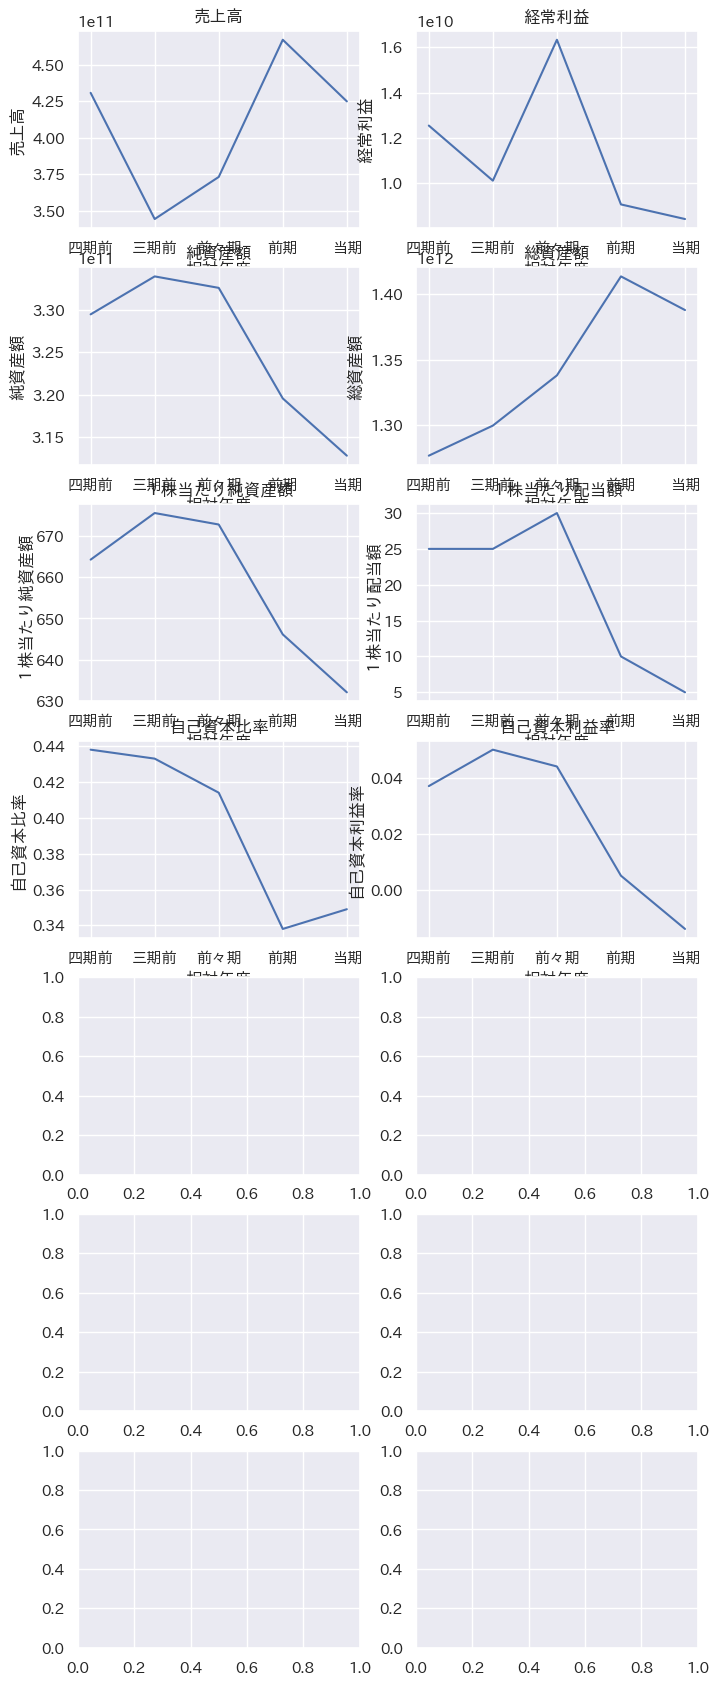

In [ ]:
import japanize_matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font="IPAexGothic")
fig, axes = plt.subplots(7, 2, figsize=(8, 21))
i, j = 0, 0
for col in df_rro.columns:
    if col != '相対年度':
        sns.lineplot(data=df_rro, x='相対年度', y=col, ax=axes[j, i])
        axes[j, i].set_title(f'{col}')
    
        if i % 2 == 1:
            i = 0
            j += 1
        else:
            i += 1
plt.tight_layout()
print(i, j)

In [ ]:
df

,要素ID,項目名,コンテキストID,相対年度,連結・個別,期間・時点,ユニットID,単位,値
0,jpdei_cor:NumberOfSubmissionDEI,提出回数、DEI,FilingDateInstant,提出日時点,その他,時点,pure,NaN,1.0
1,jpcrp_cor:RevenueIFRSSummaryOfBusinessResults,売上収益（IFRS）、経営指標等,Prior4YearDuration,四期前,その他,期間,JPY,円,996101000000.0
2,jpcrp_cor:RevenueIFRSSummaryOfBusinessResults,売上収益（IFRS）、経営指標等,Prior3YearDuration,三期前,その他,期間,JPY,円,863381000000.0
3,jpcrp_cor:RevenueIFRSSummaryOfBusinessResults,売上収益（IFRS）、経営指標等,Prior2YearDuration,前々期,その他,期間,JPY,円,911426000000.0
4,jpcrp_cor:RevenueIFRSSummaryOfBusinessResults,売上収益（IFRS）、経営指標等,Prior1YearDuration,前期,その他,期間,JPY,円,1130397000000.0
...,...,...,...,...,...,...,...,...,...
2018,jpcrp_cor:OtherInformationFinancialStatementsE...,その他、財務諸表等 [テキストブロック],CurrentYearDuration,当期,その他,期間,－,－,（３）【その他】 該当事項はありません。
2019,jpcrp_cor:OverviewOfOperationalProceduresForSh...,提出会社の株式事務の概要 [テキストブロック],FilingDateInstant,提出日時点,その他,時点,－,－,第６【提出会社の株式事務の概要】事業年度４月１日から３月31日まで定時株主総会６月中基準日３...
2020,jpcrp_cor:InformationAboutParentCompanyEtcOfRe...,提出会社の親会社等の情報 [テキストブロック],FilingDateInstant,提出日時点,その他,時点,－,－,１【提出会社の親会社等の情報】 当社には、金融商品取引法第24条の７第１項に規定する親会社等...
2021,jpcrp_cor:OtherReferenceInformationTextBlock,その他の参考情報 [テキストブロック],FilingDateInstant,提出日時点,その他,時点,－,－,２【その他の参考情報】 当事業年度の開始日から有価証券報告書提出日までの間に、次の書類を提出...


In [21]:
def convert_number(value):
    # 数値に変換できるかを確認
    try:
        # 文字列が浮動小数点数として解釈されるか試す
        num = float(value)
        # 小数点以下があるかを確認し、適切な型に変換
        if num.is_integer():
            return int(num)  # 小数点以下が0ならintに変換
        else:
            return num  # 小数点以下があればfloatのまま
    except ValueError:
        # 数値に変換できない場合はそのまま返す
        return value

def make_data_for_display(cols, df):
    # 定義した関数を適用
    df['値'] = df['値'].apply(safe_to_float)

    years = ['四期前', '三期前', '前々期', '前期', '当期']
    data_for_display = pd.DataFrame({'相対年度':years}).reset_index(drop=True)

    for col in cols:
        data = [convert_number(x) for x in df[df['項目名'].str.contains(f'{col}', na=False)][:5]['値'].reset_index(drop=True)]
        data_for_display[col] = data
    
    return data_for_display



In [ ]:
cols = ['売上高','経常利益', '純資産額', '総資産額', 
'１株当たり純資産額', '１株当たり配当額', '自己資本比率', 
'自己資本利益率', '株価収益率', 
'営業活動によるキャッシュ・フロー', '投資活動によるキャッシュ・フロー',
'財務活動によるキャッシュ・フロー', '従業員数']

temp_df = make_data_for_display(cols, df)

In [22]:
def get_financialstatement(code, cols):
    docID = search_docID(code)
    data = get_fs(docID)
    delete_files()
    fs_df = make_data_for_display(cols, df)
    
    return fs_df

In [29]:
fs_df = get_financialstatement(7974, cols)

2024-09-30
2024-09-29
2024-09-28
2024-09-27
2024-09-26
2024-09-25
2024-09-24
2024-09-23
2024-09-22
2024-09-21
2024-09-20
2024-09-19
2024-09-18
2024-09-17
2024-09-16
2024-09-15
2024-09-14
2024-09-13
2024-09-12
2024-09-11
2024-09-10
2024-09-09
2024-09-08
2024-09-07
2024-09-06
2024-09-05
2024-09-04
2024-09-03
2024-09-02
2024-09-01
2024-08-31
2024-08-30
2024-08-29
2024-08-28
2024-08-27
2024-08-26
2024-08-25
2024-08-24
2024-08-23
2024-08-22
2024-08-21
2024-08-20
2024-08-19
2024-08-18
2024-08-17
2024-08-16
2024-08-15
2024-08-14
2024-08-13
2024-08-12
2024-08-11
2024-08-10
2024-08-09
2024-08-08
2024-08-07
2024-08-06
2024-08-05
2024-08-04
2024-08-03
2024-08-02
2024-08-01
2024-07-31
2024-07-30
2024-07-29
2024-07-28
2024-07-27
2024-07-26
2024-07-25
2024-07-24
2024-07-23
2024-07-22
2024-07-21
2024-07-20
2024-07-19
2024-07-18
2024-07-17
2024-07-16
2024-07-15
2024-07-14
2024-07-13
2024-07-12
2024-07-11
2024-07-10
2024-07-09
2024-07-08
2024-07-07
2024-07-06
2024-07-05
2024-07-04
2024-07-03
2024-07-02

In [36]:
remove_cols = fs_df.columns[fs_df.dtypes==object].tolist()
remove_cols.remove('相対年度')

In [37]:
len(fs_df.columns)

13

In [48]:
import math
math.ceil(34/3)

12

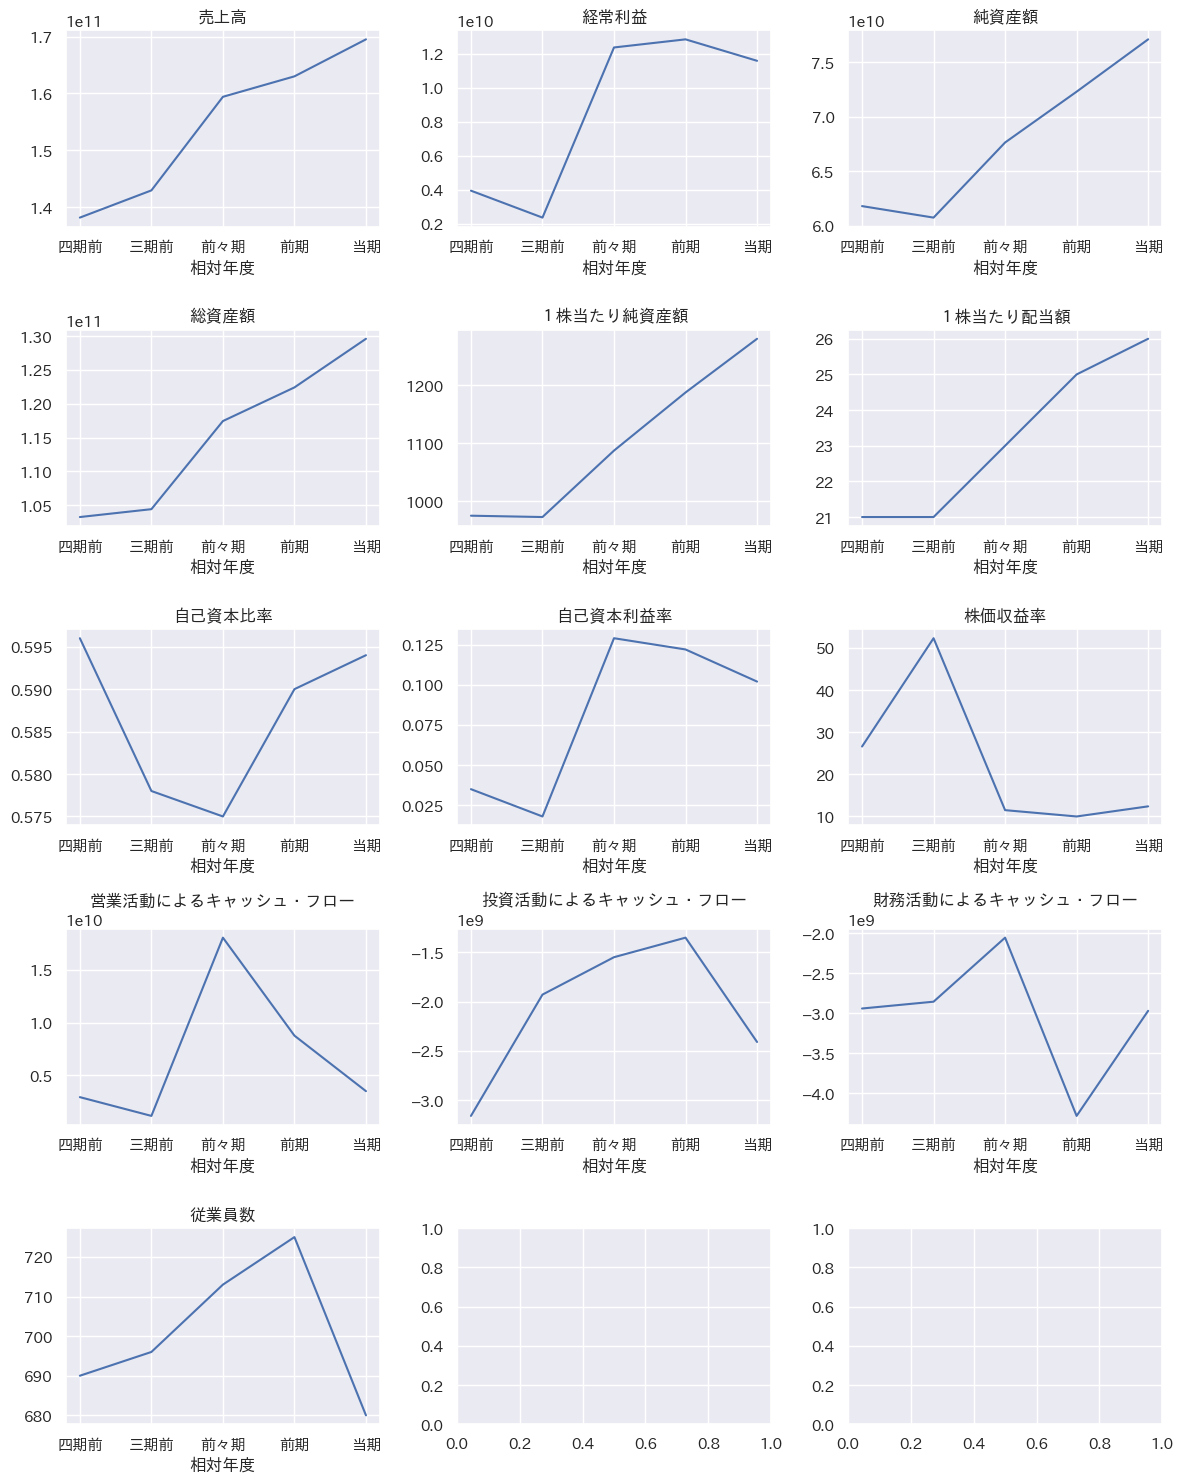

In [61]:
r = math.ceil(len(fs_df.columns)/3)
import japanize_matplotlib
sns.set(font="IPAexGothic")
fig, axes = plt.subplots(r, 3, figsize=(12, r*3))
i, j = 0, 0
for col in df_rro.columns:
    if col != '相対年度':
        sns.lineplot(data=df_rro, x='相対年度', y=col, ax=axes[j, i])
        axes[j, i].set_title(f'{col}')
        axes[j, i].set_ylabel('')
    
        if i % 3 == 2:
            i = 0
            j += 1
        else:
            i += 1
plt.tight_layout()

In [63]:
get_docID(4902, dt(2023, 5, 16))

KeyError: 'results'

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta
import yfinance as yf
import mplfinance as mpf
from shiny import reactive, render
from shiny.express import input, ui
import csv
import requests
import shutil
import os
import zipfile
import sys
import math
import urllib.request
import glob
def get_edinet_code(code):
    with open('EdinetcodeDlInfo.csv') as f:
        reader= csv.reader(f)
        #先頭行をスキップする
        next(reader)
        # 2行目以を項目行する
        col = next(reader)
        # 3行目以降をデータとする
        # rowは1行づつの配列となる。内包表記でまとめる
        data = [row for row in reader]
    
    edinet_codelist = pd.DataFrame(data, columns=col)
    return edinet_codelist[edinet_codelist['証券コード'] == f'{code}0']['ＥＤＩＮＥＴコード'].values[0]

def get_docID(code, date, api_key):
    api_key = str(api_key)
    if (api_key == "Enter EDINET API code") or (api_key is None):
        return 0
    else:
        # APIエンドポイント
        api_url = 'https://disclosure.edinet-fsa.go.jp/api/v2/documents.json'

        # パラメータ（例: 企業コードや提出日）
        params = {
            'date': date,  # 提出日
            'type': 2,             # 提出書類の種類（有価証券報告書など）
            "Subscription-Key":str(api_key)
        }

        # APIリクエスト
        response = requests.get(api_url, params=params)

        # レスポンスの確認
        if response.status_code == 200:
            data = response.json()
        elif response.status_code == 401:
            return 1
        else:
            print("Error:", response.status_code)
            return None

        # ドキュメント情報を抽出
        documents = data['results']
        if documents == []:
            return None
        
        # 結果をDataFrameに変換
        df = pd.DataFrame(documents)

        # 特定のカラムだけを選択
        df_filtered = df[['docID', 'edinetCode', 'filerName', 'docDescription']]

        # 有価証券報告書のみにフィルタリング
        df_financial = df_filtered[df_filtered['docDescription'].str.contains('有価証券報告書', na=False)]
        
        # EDINETコードを取得してフィルタリング
        edinet_code = get_edinet_code(code)
        docID_data = df_financial[df_financial['edinetCode'] == edinet_code]
            
        # docIDを返す
        return docID_data['docID'].values[0]
def get_nearest_quarter_end(current_date):
    # 現在の月を取得
    month = current_date.month

    # 四半期末日を設定
    if month <= 5:
        return current_date.replace(year=current_date.year - 1, month=12, day=31)
    else:
        return current_date.replace(month=6, day=30) # 10月～12月は9月末

def search_docID(code, api_key):
    api_key = str(api_key)
    flag = True
    current_date = dt.today().date()
    date = get_nearest_quarter_end(current_date)
    days = 0

    while flag:
        print(date)
        try:
            docID = get_docID(code, str(date), api_key)
            if docID is not None:
                flag = False
                print("取得したdocID:", docID)
            
            elif docID == 1:
                print('Please check the API code again')
                break
            
            elif docID == 0:
                print('Enter EDINET API code')
                break
            else:
                # ドキュメントが見つからない場合、日付を1日前に戻す
                date -= timedelta(days=1)
        except IndexError:
            date -= timedelta(days=1)

        days += 1
        if days > 365:
            break
    return docID

def get_fs(docID, api_key):
    api_key = str(api_key)
    url = f'https://api.edinet-fsa.go.jp/api/v2/documents/{docID}?type=5&Subscription-Key={api_key}'
    try:
            # ZIPファイルのダウンロード
        with urllib.request.urlopen(url) as res:
            content = res.read()
        output_path = os.path.join("ignored_folder", f'{docID}.zip')
        with open(output_path, 'wb') as file_out:
            file_out.write(content)
    except urllib.error.HTTPError as e:
        if e.code >= 400:
            sys.stderr.write(e.reason + '\n')
        else:
            raise e    
    
    # 解凍フォルダのパスを設定（.gitignoreで無視されるフォルダの中に保存）
    output_dir = os.path.join("ignored_folder", f"{docID}_extracted")

    # 解凍処理
    zip_path = os.path.join("ignored_folder", f'{docID}.zip')
    try:
        # ZIP形式であり、ファイルサイズが0以上であるかチェック
        if zipfile.is_zipfile(zip_path) and os.path.getsize(zip_path) > 0:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # ファイル数を確認して空かどうかを判定
                if len(zip_ref.namelist()) > 0:
                    os.makedirs(output_dir, exist_ok=True)  # 保存先フォルダが存在しない場合に作成
                    zip_ref.extractall(output_dir)
                    print(f"Extracted {zip_path} to {output_dir}")
                else:
                    print(f"{zip_path} is an empty zip file.")
        else:
            print(f"{zip_path} is not a valid or empty zip file.")
    except zipfile.BadZipFile:
        print(f"{zip_path} is corrupted or not a valid zip file.")

    # フォルダ内の'-asr-'が含まれるCSVファイルを検索
    base_folder_path = r'ignored_folder'

    # パターンを指定してファイルパスを取得
    folder_pattern = os.path.join(base_folder_path, '*_extracted', 'XBRL_TO_CSV', '*-asr-*.csv')
    matching_folders = glob.glob(folder_pattern)
    file = matching_folders[0]

    # 見つかったCSVファイルを読み込む

    try:
        return_df = pd.read_csv(file, encoding='utf-16', sep='\t')
        print(f"Loaded {file} successfully.")
        # DataFrameの確認や処理が必要であればここに追加
        # 例: print(df.head())など
    except Exception as e:
        print(f"Error loading {file}: {e}")
    
    return return_df

def delete_files():
    extracted_folder = "ignored_folder"

    # フォルダ内の全データを削除
    if os.path.exists(extracted_folder):
        shutil.rmtree(extracted_folder)
        os.makedirs(extracted_folder)  # 空のフォルダを再作成
        print(f"Deleted all contents in: {extracted_folder}")
    else:
        print(f"{extracted_folder} does not exist.")

def convert_number(value):
    # 数値に変換できるかを確認
    try:
        # 文字列が浮動小数点数として解釈されるか試す
        num = float(value)
        # 小数点以下があるかを確認し、適切な型に変換
        if num.is_integer():
            return int(num)  # 小数点以下が0ならintに変換
        else:
            return num  # 小数点以下があればfloatのまま
    except ValueError:
        # 数値に変換できない場合はそのまま返す
        return value

def make_data_for_display(cols, df):
    years = ['四期前', '三期前', '前々期', '前期', '当期']
    data_for_display = pd.DataFrame({'相対年度':years}).reset_index(drop=True)

    for col in cols:
        data = [convert_number(x) for x in df[df['項目名'].str.contains(f'{col}', na=False)][:5]['値'].reset_index(drop=True)]
        data_for_display[col] = data
    
    return data_for_display

def get_financialstatement(code, cols, api_key):
    if  (api_key == "Enter EDINET API code") or (api_key is None):
        raise ValueError('There is a problem with the API code')
    else:
        api_key = str(api_key)
        docID = search_docID(code, api_key)
        data = get_fs(docID, api_key)
        delete_files()
        fs_df = make_data_for_display(cols, data)
        
        return fs_df


In [9]:
cols = ['売上高','経常利益', '純資産額', '総資産額', 
        '１株当たり純資産額', '１株当たり配当額', '自己資本比率', 
        '自己資本利益率', '株価収益率', 
        '営業活動によるキャッシュ・フロー', '投資活動によるキャッシュ・フロー',
        '財務活動によるキャッシュ・フロー', '従業員数']
get_financialstatement(7974, cols, '5c09c7cab09f4d98b34aa3f247f7e36d')

2024-06-30
2024-06-29
2024-06-28
取得したdocID: S100TMMG
Extracted ignored_folder\S100TMMG.zip to ignored_folder\S100TMMG_extracted
Loaded ignored_folder\S100TMMG_extracted\XBRL_TO_CSV\jpcrp030000-asr-001_E02367-000_2024-03-31_01_2024-06-28.csv successfully.
Deleted all contents in: ignored_folder


,相対年度,売上高,経常利益,純資産額,総資産額,１株当たり純資産額,１株当たり配当額,自己資本比率,自己資本利益率,株価収益率,営業活動によるキャッシュ・フロー,投資活動によるキャッシュ・フロー,財務活動によるキャッシュ・フロー,従業員数
0,四期前,1308519000000,360461000000,1540900000000,1934087000000,1293.35,1090,0.7966,0.1753,19.16,347753000000,-188433000000,-111031000000,6200
1,三期前,1758910000000,678996000000,1874614000000,2446918000000,1573.48,2220,0.7660,0.2813,15.33,612106000000,-136533000000,-194938000000,6574
2,前々期,1695344000000,670813000000,2069310000000,2662384000000,1763.56,2030,0.7771,0.2423,15.24,289661000000,93699000000,-337010000000,6717
3,前期,1601677000000,601070000000,2266466000000,2854284000000,1946.55,753,0.7940,0.1996,13.82,322843000000,111507000000,-290973000000,7317
4,当期,1671865000000,680497000000,2604998000000,3151394000000,2236.45,211,0.8262,0.2015,19.45,462097000000,-630632000000,-236958000000,7724


In [10]:
x = '7974'
len(x)

4

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta
import yfinance as yf
import mplfinance as mpf
from shiny import reactive, render
from shiny.express import input, ui
import csv
import requests
import shutil
import os
import zipfile
import sys
import math
import urllib.request
import glob

#api_key : 5c09c7cab09f4d98b34aa3f247f7e36d


#株価の表示

def get_stock_price(ticker, moving_average, start, end=None):
    ticker = f'{ticker}.T'
    if end is None:
        end = dt.today()

    start_date = start
    end_date = end
    start_date_100_days_ago = start_date - timedelta(days=150)
    return_df = yf.download(ticker, start=start_date_100_days_ago, end=end_date)
    return_df = return_df.stack(future_stack=True).reset_index()

    moving_average = [int(x) for x in moving_average]
    for i in range(len(moving_average)):
        days=moving_average[i]
        return_df[f'moving_average_{days}'] = return_df['Close'].rolling(days).mean()

    return return_df.set_index('Date')

def last_year():
    current_date = dt.today().date()
    return current_date.replace(year=current_date.year-1)

#サイドバーの表示
with ui.sidebar():
    ui.input_text("ticker", "Enter Stock Code", placeholder="0000")
    ui.input_date("start", "Start Date", value=last_year(), min='1970-01-01', max=dt.today().date())
    ui.input_date("end", "End Date", value = dt.today().date(), min='1970-01-01', max=dt.today().date())
    ui.input_checkbox_group(
        "moving_average", "Moving Average",
        choices=[7, 10, 20, 30, 50, 100],
        selected=[7],
        inline=True)

    ui.input_password("api_key", "API KEY", placeholder="Enter EDINET API KEY")
    ui.input_action_button('start_search', 'Search Documents')
    ui.input_checkbox_group(
        "cols", "Data for Display",
        choices=['売上高','経常利益', '純資産額', '総資産額', 
        '１株当たり純資産額', '１株当たり配当額', '自己資本比率', 
        '自己資本利益率', '株価収益率', 
        '営業活動によるキャッシュ・フロー', '投資活動によるキャッシュ・フロー',
        '財務活動によるキャッシュ・フロー', '従業員数'],
        selected=['売上高'],
        inline=True
        )


@reactive.calc
def df():
    return get_stock_price(input.ticker(), list(input.moving_average()), input.start(), input.end())

@reactive.calc
def get_company_name():
    ticker_code = input.ticker() + ".T"
    try:
        ticker = yf.Ticker(ticker_code)
        company_name = ticker.info.get("longName", "企業名が見つかりません")
    except Exception as e:
        company_name = "取得エラー"
    return company_name

@render.text
def company_name():
    return f"企業名: {get_company_name()}"   

@reactive.calc
def figpath():
    import tempfile
    fd, path = tempfile.mkstemp(suffix = '.svg')

    start = input.start()
    end = input.end()
    data = df()

    data_for_display = data[(data.index.date>start) & (data.index.date<end)].drop('Ticker', axis=1)

    apd = []
    for days in list(input.moving_average()):
        apd.append(mpf.make_addplot(data_for_display[f'moving_average_{days}']))  


    #ろうそく足
    fig, axes = mpf.plot(data_for_display ,returnfig=True,  type='candle', volume=True, addplot=apd)

    axes[0].legend([None] * (len(apd) + 2))
    handles = axes[0].get_legend().legend_handles
    axes[0].legend(handles=handles[2:],
                   labels=list(input.moving_average()))    

    fig.savefig(path)

    return path


with ui.card(full_screen=True):
    
    @render.image
    def image():
        return {"src": str(figpath()), 
                "width": "500px", "format":"svg"}


def get_edinet_code(code):
    with open('invest_zemi\EdinetcodeDlInfo.csv') as f:
        reader= csv.reader(f)
        #先頭行をスキップする
        next(reader)
        # 2行目以を項目行する
        col = next(reader)
        # 3行目以降をデータとする
        # rowは1行づつの配列となる。内包表記でまとめる
        data = [row for row in reader]
    
    edinet_codelist = pd.DataFrame(data, columns=col)
    return edinet_codelist[edinet_codelist['証券コード'] == f'{code}0']['ＥＤＩＮＥＴコード'].values[0]

def get_docID(code, date, api_key):
    api_key = str(api_key)
    if (api_key == "Enter EDINET API code") or (api_key is None):
        return 0
    else:
        # APIエンドポイント
        api_url = 'https://disclosure.edinet-fsa.go.jp/api/v2/documents.json'

        # パラメータ（例: 企業コードや提出日）
        params = {
            'date': date,  # 提出日
            'type': 2,             # 提出書類の種類（有価証券報告書など）
            "Subscription-Key":str(api_key)
        }

        # APIリクエスト
        response = requests.get(api_url, params=params)

        # レスポンスの確認
        if response.status_code == 200:
            data = response.json()
        elif response.status_code == 401:
            return 1
        else:
            print("Error:", response.status_code)
            return None

        # ドキュメント情報を抽出
        documents = data['results']
        if documents == []:
            return None
        
        # 結果をDataFrameに変換
        df = pd.DataFrame(documents)

        # 特定のカラムだけを選択
        df_filtered = df[['docID', 'edinetCode', 'filerName', 'docDescription']]

        # 有価証券報告書のみにフィルタリング
        df_financial = df_filtered[df_filtered['docDescription'].str.contains('有価証券報告書', na=False)]
        
        # EDINETコードを取得してフィルタリング
        edinet_code = get_edinet_code(code)
        docID_data = df_financial[df_financial['edinetCode'] == edinet_code]
            
        # docIDを返す
        return docID_data['docID'].values[0]

def get_nearest_quarter_end(current_date):
    # 現在の月を取得
    month = current_date.month

    # 四半期末日を設定
    if month <= 5:
        return current_date.replace(year=current_date.year - 1, month=12, day=31)
    else:
        return current_date.replace(month=6, day=30)


def search_docID(code, api_key):
    api_key = str(api_key)
    if len(code) >= 4:
        flag = True
    else:
        flag = False
    current_date = dt.today().date()
    date = get_nearest_quarter_end(current_date)
    days = 0

    while flag:
        print(date)
        try:
            docID = get_docID(code, str(date), api_key)
            if docID is not None:
                flag = False
                print("取得したdocID:", docID)
            
            elif docID == 1:
                print('Please check the API code again')
                break
            
            elif docID == 0:
                print('Enter EDINET API code')
                break
            else:
                # ドキュメントが見つからない場合、日付を1日前に戻す
                date -= timedelta(days=1)
        except IndexError:
            date -= timedelta(days=1)

        days += 1
        if days > 365:
            break
    return docID

def get_fs(docID, api_key):
    api_key = str(api_key)
    url = f'https://api.edinet-fsa.go.jp/api/v2/documents/{docID}?type=5&Subscription-Key={api_key}'
    try:
            # ZIPファイルのダウンロード
        with urllib.request.urlopen(url) as res:
            content = res.read()
        output_path = os.path.join("invest_zemi\ignored_folder", f'{docID}.zip')
        with open(output_path, 'wb') as file_out:
            file_out.write(content)
    except urllib.error.HTTPError as e:
        if e.code >= 400:
            sys.stderr.write(e.reason + '\n')
        else:
            raise e    
    
    # 解凍フォルダのパスを設定（.gitignoreで無視されるフォルダの中に保存）
    output_dir = os.path.join("invest_zemi\ignored_folder", f"{docID}_extracted")

    # 解凍処理
    zip_path = os.path.join("invest_zemi\ignored_folder", f'{docID}.zip')
    try:
        # ZIP形式であり、ファイルサイズが0以上であるかチェック
        if zipfile.is_zipfile(zip_path) and os.path.getsize(zip_path) > 0:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # ファイル数を確認して空かどうかを判定
                if len(zip_ref.namelist()) > 0:
                    os.makedirs(output_dir, exist_ok=True)  # 保存先フォルダが存在しない場合に作成
                    zip_ref.extractall(output_dir)
                    print(f"Extracted {zip_path} to {output_dir}")
                else:
                    print(f"{zip_path} is an empty zip file.")
        else:
            print(f"{zip_path} is not a valid or empty zip file.")
    except zipfile.BadZipFile:
        print(f"{zip_path} is corrupted or not a valid zip file.")

    # フォルダ内の'-asr-'が含まれるCSVファイルを検索
    base_folder_path = r'invest_zemi\ignored_folder'

    # パターンを指定してファイルパスを取得
    folder_pattern = os.path.join(base_folder_path, '*_extracted', 'XBRL_TO_CSV', '*-asr-*.csv')
    matching_folders = glob.glob(folder_pattern)
    file = matching_folders[0]

    # 見つかったCSVファイルを読み込む

    try:
        return_df = pd.read_csv(file, encoding='utf-16', sep='\t')
        print(f"Loaded {file} successfully.")
        # DataFrameの確認や処理が必要であればここに追加
        # 例: print(df.head())など
    except Exception as e:
        print(f"Error loading {file}: {e}")
    
    return return_df

def delete_files():
    extracted_folder = "invest_zemi\ignored_folder"

    # フォルダ内の全データを削除
    if os.path.exists(extracted_folder):
        shutil.rmtree(extracted_folder)
        os.makedirs(extracted_folder)  # 空のフォルダを再作成
        print(f"Deleted all contents in: {extracted_folder}")
    else:
        print(f"{extracted_folder} does not exist.")

def convert_number(value):
    # 数値に変換できるかを確認
    try:
        # 文字列が浮動小数点数として解釈されるか試す
        num = float(value)
        # 小数点以下があるかを確認し、適切な型に変換
        if num.is_integer():
            return int(num)  # 小数点以下が0ならintに変換
        else:
            return num  # 小数点以下があればfloatのまま
    except ValueError:
        # 数値に変換できない場合はそのまま返す
        return value

def make_data_for_display(cols, df):
    years = ['四期前', '三期前', '前々期', '前期', '当期']
    data_for_display = pd.DataFrame({'相対年度':years}).reset_index(drop=True)

    for col in cols:
        data = [convert_number(x) for x in df[df['項目名'].str.contains(f'{col}', na=False)][:5]['値'].reset_index(drop=True)]
        data_for_display[col] = data
    
    return data_for_display

def get_financialstatement(code, api_key):
    if  (api_key == "Enter EDINET API code") or (api_key is None):
        raise ValueError('There is a problem with the API code')
    else:
        api_key = str(api_key)
        docID = search_docID(code, api_key)
        data = get_fs(docID, api_key)
        delete_files()
        
        return data

data = reactive.value(pd.DataFrame())

@reactive.effect
@reactive.event(input.start_search)
def _():
    data.set(get_financialstatement(input.ticker(), input.api_key()))


@reactive.calc
def fs_df():
    return make_data_for_display(list(input.cols()), data())



@reactive.calc
def figpath2():
    import tempfile
    fd, path = tempfile.mkstemp(suffix = '.svg')
    data = fs_df()

    remove_cols = data.columns[data.dtypes==object].tolist()
    remove_cols.remove('相対年度')

    r = math.ceil((len(data.columns)-1)/3)
    import japanize_matplotlib
    sns.set(font="IPAexGothic")
    fig, axes = plt.subplots(r, 3, figsize=(12, r*3))
    i, j = 0, 0
    if r == 1:
        for col in data.columns:
            if col != '相対年度':
                sns.lineplot(data=data, x='相対年度', y=col, ax=axes[i])
                axes[i].set_title(f'{col}')
                axes[i].set_ylabel('')
                i += 1

        plt.tight_layout()

    else:
        for col in data.columns:
            if col != '相対年度':
                sns.lineplot(data=data, x='相対年度', y=col, ax=axes[j, i])
                axes[j, i].set_title(f'{col}')
                axes[j, i].set_ylabel('')
            
                if i % 3 == 2:
                    i = 0
                    j += 1
                else:
                    i += 1
        plt.tight_layout()

    fig.savefig(path)

    return path


with ui.card(full_screen=True):
    
    @render.image
    def image2():
        return {"src": str(figpath2()), 
                "width": "800px", "format":"svg"}

